In [71]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("datadone.csv", header=None)
np_data = df_data.values

In [95]:
np.random.shuffle(np_data)
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_fft = np_data[:, 1228:1535]
np_classe = np_data[:, 1535:]

In [96]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_fft = torch.tensor(np_fft, dtype=torch.float32).reshape(np_fft.shape[0], 1, np_fft.shape[1])
ts_classe = torch.tensor(np_classe, dtype=torch.float32)
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [97]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train_v = ts_vitesse[:threshold1]
X_train_f = ts_frf[:threshold1]
X_train_fft = ts_fft[:threshold1]
X_train = ts_feature[:threshold1]
Y_train = ts_classe[:threshold1]
X_valid_v = ts_vitesse[threshold1:threshold2]
X_valid_f = ts_frf[threshold1:threshold2]
X_valid_fft = ts_fft[threshold1:threshold2]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_classe[threshold1:threshold2]
X_test_v = ts_vitesse[threshold2:]
X_test_f = ts_frf[threshold2:]
X_test_fft = ts_fft[threshold2:]
X_test = ts_feature[threshold2:]
Y_test = ts_classe[threshold2:]

In [98]:
np_label = Y_train.argmax(axis=1)
index_2 = np.where(np_label == 2)
index_3 = np.where(np_label == 3)
index_4 = np.where(np_label == 4)

In [99]:
X_v_2 = X_train_v[index_2]
X_v_3 = X_train_v[index_3]
X_v_4 = X_train_v[index_4]
X_frf_2 = X_train_f[index_2]
X_frf_3 = X_train_f[index_3]
X_frf_4 = X_train_f[index_4]
X_feature_2 = X_train[index_2]
X_feature_3 = X_train[index_3]
X_feature_4 = X_train[index_4]
Y_2 = Y_train[index_2]
Y_3 = Y_train[index_3]
Y_4 = Y_train[index_4]

In [78]:
X_train_f = torch.load('X_train_f_new.pt').detach()
Y_train_f = torch.load('Y_train_f_new.pt')

In [100]:
X_valid_f = torch.load('X_valid_f.pt').detach()
Y_valid = torch.load('Y_valid.pt')
X_test_f = torch.load('X_test_f.pt').detach()
Y_test = torch.load('Y_test.pt')

In [8]:
def resample(X, Y, num):
  n = num // len(X)
  X_new = X
  Y_new = Y
  for i in range(n):
    X_new = torch.concat((X_new, X), dim=0)
    Y_new = torch.concat((Y_new, Y), dim=0)
  return X_new, Y_new

In [13]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet_f = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [104]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 10, 1e-3, 0, 64, try_gpu()

In [79]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(5), range(5))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

def evaluate_net(net, X_test, Y_test):
    net.cpu()
    Y_pred = net(X_test)
    np_Y_pred = Y_pred.argmax(axis=1).numpy()
    np_Y_test = Y_test.argmax(axis=1).numpy()
    f1s = f1_score(np_Y_test, np_Y_pred, average='weighted')
    print(f'F1 score: {f1s:.3f}')
    cm = confusion_matrix(np_Y_test, np_Y_pred)
    plot_confusion_matrix(cm)

In [178]:
np.unique(Y_train.argmax(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([4764, 6178, 1257,  141,   22], dtype=int64))

In [160]:
X_frf_2_new, Y_2_new = resample(X_frf_2, Y_2, 1500)
X_frf_3_new, Y_3_new = resample(X_frf_3, Y_3, 1500)
X_frf_4_new, Y_4_new = resample(X_frf_4, Y_4, 1500)

X_train_f_new = torch.concat((X_train_f, X_frf_2_new, X_frf_3_new, X_frf_4_new), dim=0)
Y_train_new = torch.concat((Y_train, Y_2_new, Y_3_new, Y_4_new), dim=0)
index_new = np.arange(len(X_train_f_new))
np.random.shuffle(index_new)
X_train_f_new = X_train_f_new[index_new]
Y_train_new = Y_train_new[index_new]

loss 0.009, train acc 0.997, test acc 0.920
1980.6 examples/sec on cuda:0


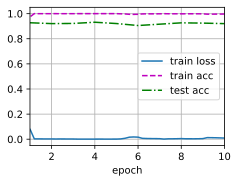

In [161]:
train_accuracy(resnet_f, X_train_f_new, Y_train_new, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.928


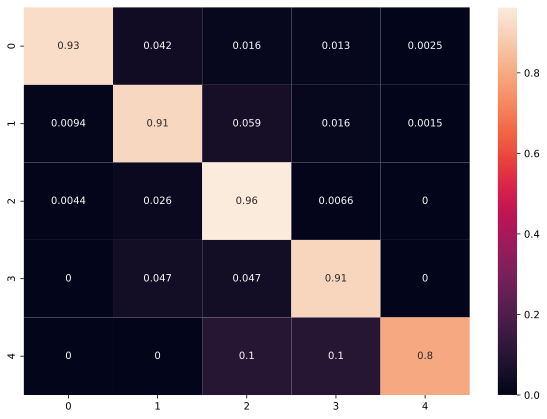

In [162]:
evaluate_net(resnet_f, X_test_f, Y_test)

loss 0.004, train acc 0.999, test acc 0.944
1643.9 examples/sec on cuda:0


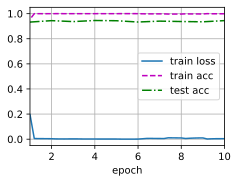

In [166]:
X_frf_2_new, Y_2_new = resample(X_frf_2, Y_2, 1000)
X_frf_3_new, Y_3_new = resample(X_frf_3, Y_3, 1000)
X_frf_4_new, Y_4_new = resample(X_frf_4, Y_4, 1000)

X_train_f_new = torch.concat((X_train_f, X_frf_2_new, X_frf_3_new, X_frf_4_new), dim=0)
Y_train_new = torch.concat((Y_train, Y_2_new, Y_3_new, Y_4_new), dim=0)
index_new = np.arange(len(X_train_f_new))
np.random.shuffle(index_new)
X_train_f_new = X_train_f_new[index_new]
Y_train_new = Y_train_new[index_new]

train_accuracy(resnet_f, X_train_f_new, Y_train_new, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.954


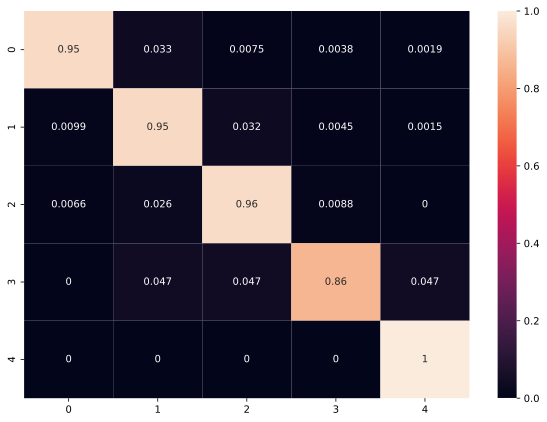

In [167]:
evaluate_net(resnet_f, X_test_f, Y_test)

loss 0.004, train acc 0.999, test acc 0.910
1782.1 examples/sec on cuda:0


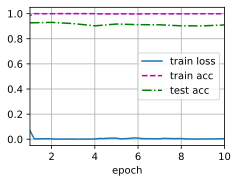

In [168]:
X_frf_2_new, Y_2_new = resample(X_frf_2, Y_2, 2000)
X_frf_3_new, Y_3_new = resample(X_frf_3, Y_3, 2000)
X_frf_4_new, Y_4_new = resample(X_frf_4, Y_4, 2000)

X_train_f_new = torch.concat((X_train_f, X_frf_2_new, X_frf_3_new, X_frf_4_new), dim=0)
Y_train_new = torch.concat((Y_train, Y_2_new, Y_3_new, Y_4_new), dim=0)
index_new = np.arange(len(X_train_f_new))
np.random.shuffle(index_new)
X_train_f_new = X_train_f_new[index_new]
Y_train_new = Y_train_new[index_new]

train_accuracy(resnet_f, X_train_f_new, Y_train_new, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.922


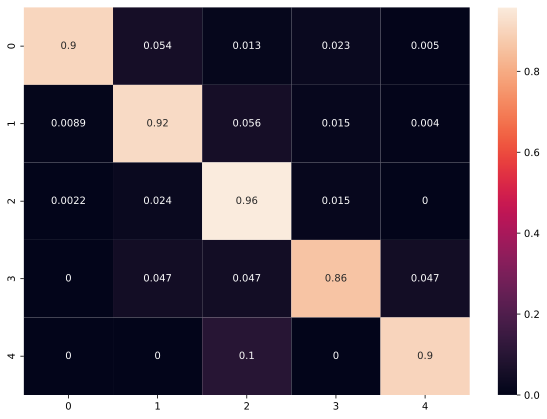

In [169]:
evaluate_net(resnet_f, X_test_f, Y_test)

loss 0.007, train acc 0.998, test acc 0.911
1944.3 examples/sec on cuda:0


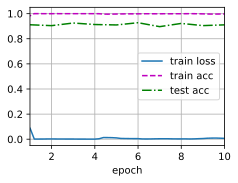

In [171]:
np_X_train_f = X_train_f.numpy().reshape(X_train_f.shape[0], X_train_f.shape[2])
np_Y_train = Y_train.numpy().argmax(axis=1)
smote = SMOTE(sampling_strategy = {3: 1000, 4: 1000})
np_X_train_f_smt, np_Y_train_f_smt = smote.fit_resample(np_X_train_f, np_Y_train)
X_train_f_smt = torch.tensor(np_X_train_f_smt, dtype=torch.float32).reshape(np_X_train_f_smt.shape[0], 1, np_X_train_f_smt.shape[1])
Y_train_f_smt = torch.tensor(pd.get_dummies(np_Y_train_f_smt).values, dtype=torch.float32)

train_accuracy(resnet_f, X_train_f_new, Y_train_new, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.924


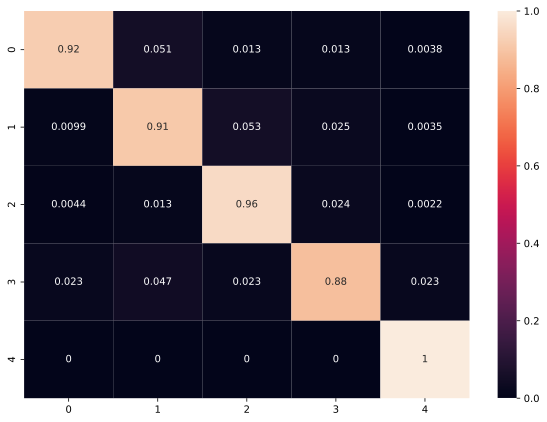

In [172]:
evaluate_net(resnet_f, X_test_f, Y_test)

In [180]:
np_X_train_f = X_train_f.numpy().reshape(X_train_f.shape[0], X_train_f.shape[2])
np_Y_train = Y_train.numpy().argmax(axis=1)
smote = SMOTE(sampling_strategy = {2: 1500, 3: 1500, 4: 1500})
np_X_train_f_smt, np_Y_train_f_smt = smote.fit_resample(np_X_train_f, np_Y_train)
X_train_f_smt = torch.tensor(np_X_train_f_smt, dtype=torch.float32).reshape(np_X_train_f_smt.shape[0], 1, np_X_train_f_smt.shape[1])
Y_train_f_smt = torch.tensor(pd.get_dummies(np_Y_train_f_smt).values, dtype=torch.float32)

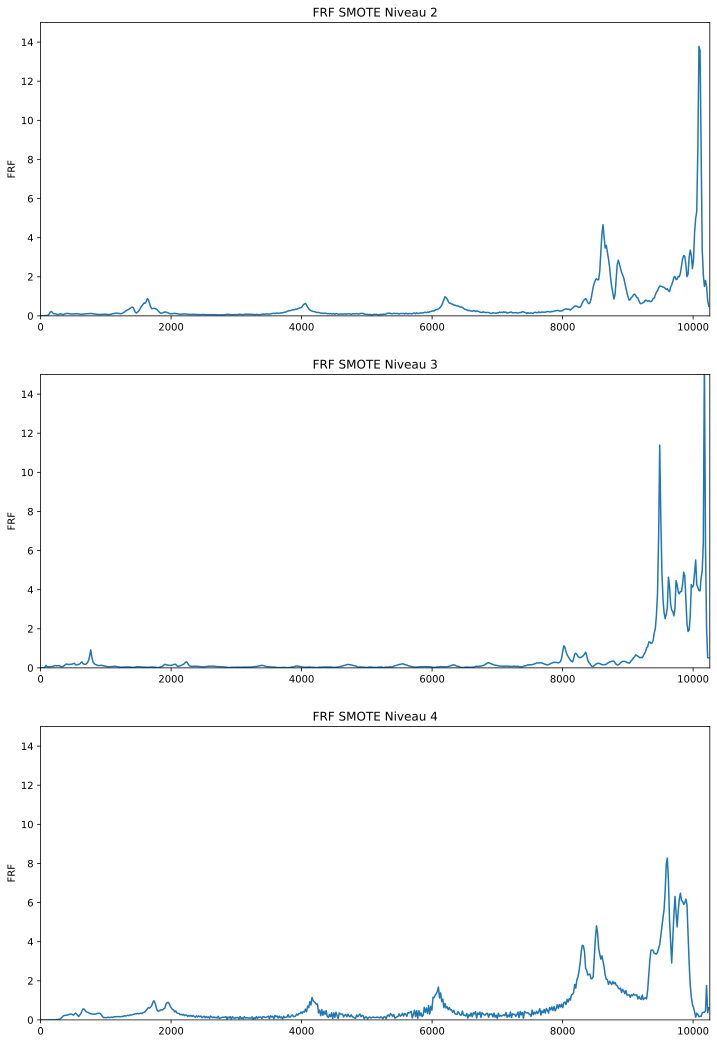

In [191]:
fig, ax = plt.subplots(3, figsize=(12,18))
frequence = np.arange(0, 614*16.70473, 16.70473)
ax[0].plot(frequence, X_train_f_smt[12500].squeeze())
ax[0].set_title("FRF SMOTE Niveau 2")
ax[0].set(xlim=(0, 10256), ylim=(0, 15), ylabel="FRF")
ax[1].plot(frequence, X_train_f_smt[13200].squeeze())
ax[1].set_title("FRF SMOTE Niveau 3")
ax[1].set(xlim=(0, 10256), ylim=(0, 15), ylabel="FRF")
ax[2].plot(frequence, X_train_f_smt[14000].squeeze())
ax[2].set_title("FRF SMOTE Niveau 4")
ax[2].set(xlim=(0, 10256), ylim=(0, 15), ylabel="FRF")
plt.show()


loss 0.009, train acc 0.997, test acc 0.918
1946.7 examples/sec on cuda:0


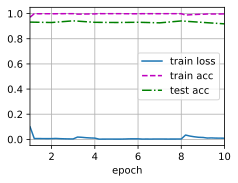

In [164]:
num_epochs, lr, weight_decay, batch_size, device = 10, 1e-3, 0, 64, try_gpu()
train_accuracy(resnet_f, X_train_f_smt, Y_train_f_smt, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.938


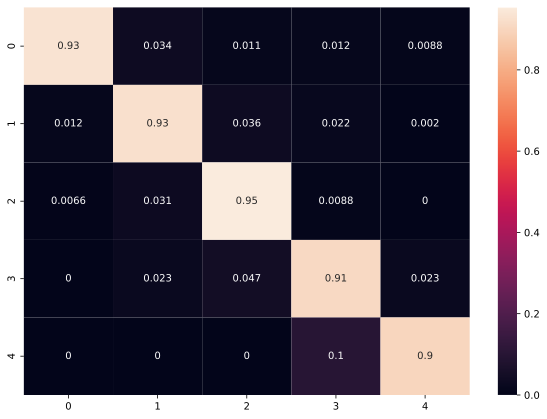

In [165]:
evaluate_net(resnet_f, X_test_f, Y_test)

loss 0.005, train acc 0.998, test acc 0.922
1888.4 examples/sec on cuda:0


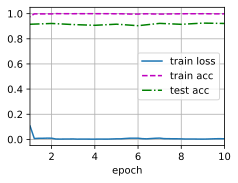

In [173]:
np_X_train_f = X_train_f.numpy().reshape(X_train_f.shape[0], X_train_f.shape[2])
np_Y_train = Y_train.numpy().argmax(axis=1)
smote = SMOTE(sampling_strategy = {2: 2000, 3: 2000, 4: 2000})
np_X_train_f_smt, np_Y_train_f_smt = smote.fit_resample(np_X_train_f, np_Y_train)
X_train_f_smt = torch.tensor(np_X_train_f_smt, dtype=torch.float32).reshape(np_X_train_f_smt.shape[0], 1, np_X_train_f_smt.shape[1])
Y_train_f_smt = torch.tensor(pd.get_dummies(np_Y_train_f_smt).values, dtype=torch.float32)

train_accuracy(resnet_f, X_train_f_smt, Y_train_f_smt, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.936


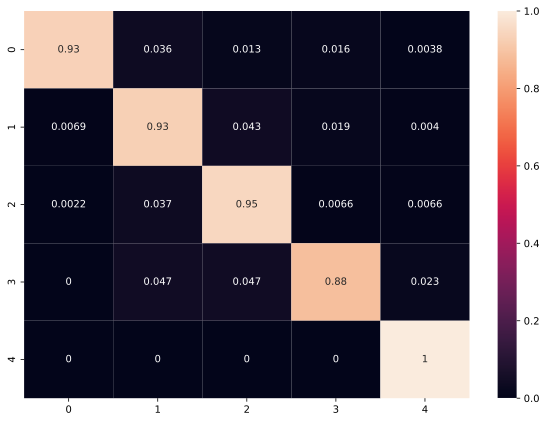

In [174]:
evaluate_net(resnet_f, X_test_f, Y_test)

In [175]:
ada = ADASYN(random_state=42)
np_X_train_f_ada, np_Y_train_f_ada = ada.fit_resample(np_X_train_f, np_Y_train)
X_train_f_ada = torch.tensor(np_X_train_f_ada, dtype=torch.float32).reshape(np_X_train_f_ada.shape[0], 1, np_X_train_f_ada.shape[1])
Y_train_f_ada = torch.tensor(pd.get_dummies(np_Y_train_f_ada).values, dtype=torch.float32)

In [179]:
np.unique(np_Y_train_f_ada, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([5886, 6178, 6204, 6174, 6180], dtype=int64))

loss 0.007, train acc 0.998, test acc 0.785
1971.6 examples/sec on cuda:0


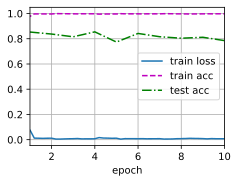

In [176]:
train_accuracy(resnet_f, X_train_f_ada, Y_train_f_ada, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.830


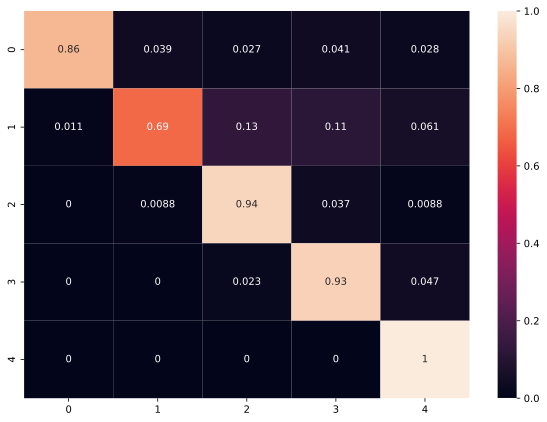

In [177]:
evaluate_net(resnet_f, X_test_f, Y_test)